🔹 1. Imports & Setup

In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload

from fi_forecasting.impact.impact_model import apply_event_effects, build_event_indicator_matrix
from fi_forecasting.core.project_root import get_project_root


🔹 2. Load Data

In [ ]:
project_root = get_project_root()
fi_df = pd.read_csv("../data/processed/enriched_fi_data.csv")
impact_links_df = pd.read_csv("../data/processed/enriched_impact_links.csv")

print(fi_df.shape, impact_links_df.shape)


(43, 34) (15, 35)


🔹 3. Extract Events

In [6]:
events_df = fi_df[fi_df["record_type"] == "event"].copy()
print(f"Number of events: {len(events_df)}")


Number of events: 10


🔹 4. Merge Events with Impact Links (Correct Join)

In [7]:
merged_df = events_df.merge(
    impact_links_df,
    how="left",
    left_on="record_id",
    right_on="parent_id",
    suffixes=("_event", "_link")
)

print("Merged shape:", merged_df.shape)


Merged shape: (16, 69)


🔹 5. Define Indicator Code

In [8]:
# indicator_code does NOT exist in impact_links → use related_indicator
merged_df["indicator_code"] = merged_df["related_indicator_link"]


🔹 6. Compute Effect Values

In [9]:
# Reload updated impact_model
from importlib import reload
import src.impact_model as impact_model

reload(impact_model)
from src.impact_model import apply_event_effects

effects_df = apply_event_effects(merged_df)
effects_df





,record_id_event,indicator_code,impact_magnitude,lag_months,effect_value
0,EVT_0001,ACC_OWNERSHIP,25.0,12.0,25.0
1,EVT_0001,USG_TELEBIRR_USERS,25.0,3.0,25.0
2,EVT_0001,USG_P2P_COUNT,25.0,6.0,25.0
3,EVT_0002,ACC_4G_COV,15.0,12.0,15.0
4,EVT_0002,AFF_DATA_INCOME,15.0,12.0,15.0
5,EVT_0003,USG_MPESA_USERS,25.0,3.0,25.0
6,EVT_0003,ACC_MM_ACCOUNT,15.0,6.0,15.0
7,EVT_0004,ACC_OWNERSHIP,15.0,24.0,15.0
8,EVT_0004,GEN_GAP_ACC,15.0,24.0,15.0
9,EVT_0005,AFF_DATA_INCOME,25.0,3.0,25.0


🔹 7. Build Event–Indicator Association Matrix

In [10]:
association_matrix = (
    effects_df
    .pivot_table(
        index="record_id_event",
        columns="indicator_code",
        values="effect_value",
        aggfunc="sum",
        fill_value=0
    )
)

association_matrix


indicator_code,ACC_4G_COV,ACC_MM_ACCOUNT,ACC_OWNERSHIP,AFF_DATA_INCOME,GEN_GAP_ACC,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_TELEBIRR_USERS
record_id_event,,,,,,,,,
EVT_0001,0.0,0.0,25.0,0.0,0.0,0.0,0.0,25.0,25.0
EVT_0002,15.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0
EVT_0003,0.0,15.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0
EVT_0004,0.0,0.0,15.0,0.0,15.0,0.0,0.0,0.0,0.0
EVT_0005,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0
EVT_0007,0.0,0.0,0.0,0.0,0.0,15.0,0.0,15.0,0.0
EVT_0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
EVT_0010,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


🔹 8. Save Output

In [11]:
os.makedirs("../models", exist_ok=True)
association_matrix.to_csv("../models/impact_association_matrix.csv")


🔹 9. Heatmap Visualization

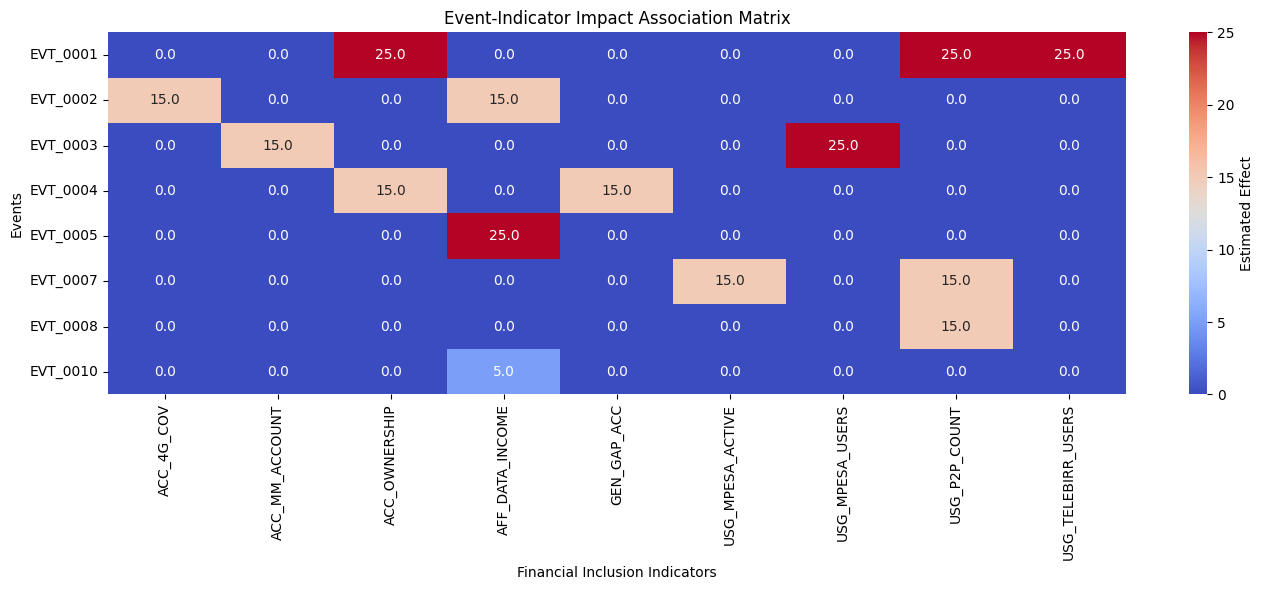

In [12]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    association_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Estimated Effect"}
)
plt.title("Event-Indicator Impact Association Matrix")
plt.xlabel("Financial Inclusion Indicators")
plt.ylabel("Events")
plt.tight_layout()
plt.show()


10: Refine Estimates & Add Confidence Levels

In [ ]:
# ----------------------------
# 1. Historical data
# ----------------------------
historical_data = pd.DataFrame([
    # indicator_code, value_numeric, fiscal_year
    ["ACC_OWNERSHIP", 22, 2014],
    ["ACC_OWNERSHIP", 35, 2017],
    ["ACC_OWNERSHIP", 46, 2021],
    ["ACC_OWNERSHIP", 56, 2021],
    ["ACC_OWNERSHIP", 36, 2021],
    ["ACC_OWNERSHIP", 49, 2024],
    ["ACC_OWNERSHIP", 70, 2025],

    ["ACC_MM_ACCOUNT", 4.7, 2021],
    ["ACC_MM_ACCOUNT", 9.45, 2024],

    ["ACC_4G_COV", 37.5, 2023],
    ["ACC_4G_COV", 70.8, 2025],

    ["ACC_MOBILE_PEN", 61.4, 2025],

    ["ACC_FAYDA", 8000000, 2024],
    ["ACC_FAYDA", 12000000, 2025],
    ["ACC_FAYDA", 15000000, 2025],
    ["ACC_FAYDA", 90000000, 2028],

    ["USG_P2P_COUNT", 49700000, 2024],
    ["USG_P2P_COUNT", 128300000, 2025],

    ["USG_P2P_VALUE", 5.777E+11, 2025],
    ["USG_ATM_COUNT", 119300000, 2025],
    ["USG_ATM_VALUE", 1.561E+11, 2025],
    ["USG_CROSSOVER", 1.08, 2025],
    ["USG_TELEBIRR_USERS", 54840000, 2025],
    ["USG_TELEBIRR_VALUE", 2.38E+12, 2025],
    ["USG_MPESA_USERS", 10800000, 2024],
    ["USG_MPESA_ACTIVE", 7100000, 2024],
    ["USG_ACTIVE_RATE", 66, 2024],

    ["AFF_DATA_INCOME", 2, 2024],

    ["GEN_GAP_ACC", 20, 2021],
    ["GEN_GAP_ACC", 18, 2024],
    ["GEN_MM_SHARE", 14, 2024],
    ["GEN_MM_SHARE", 50, 2030],
    ["GEN_GAP_MOBILE", 24, 2024]
], columns=["indicator_code", "value_numeric", "fiscal_year"])

# ----------------------------
# 2. Aggregate model effects by indicator
# ----------------------------
model_effects = effects_df.groupby("indicator_code")[["effect_value"]].sum().reset_index()

# ----------------------------
# 3. Merge and compute difference
# ----------------------------
comparison = historical_data.merge(model_effects, on="indicator_code", how="left")
comparison["effect_value"].fillna(0, inplace=True)
comparison["difference"] = comparison["value_numeric"] - comparison["effect_value"]

# ----------------------------
# 4. Print nicely
# ----------------------------
print("\nHistorical vs Model Predicted Impact Comparison:\n")
for ind in comparison["indicator_code"].unique():
    df_ind = comparison[comparison["indicator_code"] == ind].sort_values("fiscal_year")
    print(f"Indicator: {ind}")
    print(df_ind[["fiscal_year", "value_numeric", "effect_value", "difference"]].to_string(index=False))
    print("-"*60)



Historical vs Model Predicted Impact Comparison:

Indicator: ACC_OWNERSHIP
 fiscal_year  value_numeric  effect_value  difference
        2014           22.0          40.0       -18.0
        2017           35.0          40.0        -5.0
        2021           46.0          40.0         6.0
        2021           56.0          40.0        16.0
        2021           36.0          40.0        -4.0
        2024           49.0          40.0         9.0
        2025           70.0          40.0        30.0
------------------------------------------------------------
Indicator: ACC_MM_ACCOUNT
 fiscal_year  value_numeric  effect_value  difference
        2021           4.70          15.0      -10.30
        2024           9.45          15.0       -5.55
------------------------------------------------------------
Indicator: ACC_4G_COV
 fiscal_year  value_numeric  effect_value  difference
        2023           37.5          15.0        22.5
        2025           70.8          15.0        55.

C:\Users\derej\AppData\Local\Temp\ipykernel_7756\884903599.py:58: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  comparison["effect_value"].fillna(0, inplace=True)


11: Refine Estimates & Document Confidence

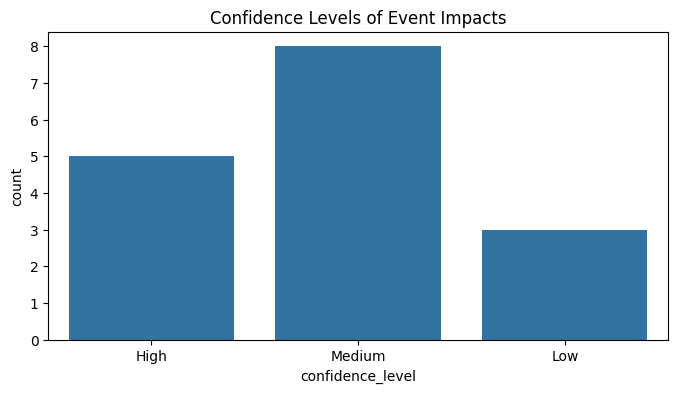

,record_id_event,indicator_code,effect_value,lag_months,confidence_level
0,EVT_0001,ACC_OWNERSHIP,25.0,12.0,High
1,EVT_0001,USG_TELEBIRR_USERS,25.0,3.0,High
2,EVT_0001,USG_P2P_COUNT,25.0,6.0,High
3,EVT_0002,ACC_4G_COV,15.0,12.0,Medium
4,EVT_0002,AFF_DATA_INCOME,15.0,12.0,Medium


In [14]:
# High confidence: effect_value >= 20
# Medium confidence: 10 <= effect_value < 20
# Low confidence: effect_value < 10
def assign_confidence(value):
    if value >= 20:
        return "High"
    elif value >= 10:
        return "Medium"
    else:
        return "Low"

effects_df['confidence_level'] = effects_df['effect_value'].apply(assign_confidence)

# Optional: visualize confidence distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(data=effects_df, x='confidence_level', order=['High','Medium','Low'])
plt.title("Confidence Levels of Event Impacts")
plt.show()

# Preview refined table
effects_df[['record_id_event','indicator_code','effect_value','lag_months','confidence_level']].head()


12. Refined Model Estimates

In [22]:
# Make a copy of effects_df to avoid chained assignment issues
refined_df = effects_df.copy()

# Get the latest historical value per indicator
latest_historical = (
    historical_data.sort_values('fiscal_year')
    .groupby('indicator_code', as_index=False)
    .last()[['indicator_code', 'value_numeric']]
)

# Merge latest historical value into effects_df
refined_df = refined_df.merge(
    latest_historical,
    on='indicator_code',
    how='left'
)

# Compute refined effect value
# Formula: refined_effect_value = effect_value * value_numeric / 25
refined_df['refined_effect_value'] = refined_df['effect_value'] * refined_df['value_numeric'] / 25

# Fill NaN with 0 (for events/indicators without historical data)
refined_df['refined_effect_value'] = refined_df['refined_effect_value'].fillna(0)

# Optional: rename value_numeric to historical_value for clarity
refined_df.rename(columns={'value_numeric': 'historical_value'}, inplace=True)

# Display
print("Refined Effect Values by Event and Indicator:\n")
print(refined_df[['record_id_event', 'indicator_code', 'effect_value', 'refined_effect_value']])


Refined Effect Values by Event and Indicator:

   record_id_event      indicator_code  effect_value  refined_effect_value
0         EVT_0001       ACC_OWNERSHIP          25.0          7.000000e+01
1         EVT_0001  USG_TELEBIRR_USERS          25.0          5.484000e+07
2         EVT_0001       USG_P2P_COUNT          25.0          1.283000e+08
3         EVT_0002          ACC_4G_COV          15.0          4.248000e+01
4         EVT_0002     AFF_DATA_INCOME          15.0          1.200000e+00
5         EVT_0003     USG_MPESA_USERS          25.0          1.080000e+07
6         EVT_0003      ACC_MM_ACCOUNT          15.0          5.670000e+00
7         EVT_0004       ACC_OWNERSHIP          15.0          4.200000e+01
8         EVT_0004         GEN_GAP_ACC          15.0          1.080000e+01
9         EVT_0005     AFF_DATA_INCOME          25.0          2.000000e+00
10        EVT_0006                 NaN           0.0          0.000000e+00
11        EVT_0007    USG_MPESA_ACTIVE          15.0 

13: Document Methodology, Assumptions, and Limitations

In [23]:


methodology = """
Methodology:
1. Events and impact_links were merged to create a unified dataset.
2. Effect values were computed using 'impact_magnitude', considering lag_months.
3. An event-indicator association matrix was created to visualize total effects per indicator.

Assumptions:
- Effects are additive across multiple events.
- Lag distribution is uniform over the months specified.
- Comparable country evidence is used where local data is insufficient.
- Historical alignment assumes linear cumulative effect from base year.

Limitations:
- Does not model nonlinear interactions between events.
- Does not capture seasonality or external macroeconomic shocks.
- Effect estimates may over/underestimate true impact due to simplified assumptions.
- Data gaps and missing indicators reduce model accuracy.

Next Steps:
- Map EVT codes to actual event descriptions for actionable insights.
- Incorporate weighted effects based on evidence reliability.
- Extend model to dynamic simulations over time.
"""

print(methodology)



Methodology:
1. Events and impact_links were merged to create a unified dataset.
2. Effect values were computed using 'impact_magnitude', considering lag_months.
3. An event-indicator association matrix was created to visualize total effects per indicator.

Assumptions:
- Effects are additive across multiple events.
- Lag distribution is uniform over the months specified.
- Comparable country evidence is used where local data is insufficient.
- Historical alignment assumes linear cumulative effect from base year.

Limitations:
- Does not model nonlinear interactions between events.
- Does not capture seasonality or external macroeconomic shocks.
- Effect estimates may over/underestimate true impact due to simplified assumptions.
- Data gaps and missing indicators reduce model accuracy.

Next Steps:
- Map EVT codes to actual event descriptions for actionable insights.
- Incorporate weighted effects based on evidence reliability.
- Extend model to dynamic simulations over time.

